# Entrenamiento de Modelos

## 1. Introducción
- Objetivo del entrenamiento
- Breve descripción del enfoque/modelo

## 2. Carga de datos preprocesados
- Importar los conjuntos de train, val y test
- Verificar la estructura y balanceo

In [6]:
import pandas as pd

# Importar los conjuntos de train, val y test
df_train = pd.read_csv('../data/hagrid_train.csv')
df_val = pd.read_csv('../data/hagrid_val.csv')
df_test = pd.read_csv('../data/hagrid_test.csv')

# Verificar la estructura
print("Train columns:", df_train.columns)
print("Train shape:", df_train.shape)
print("Val shape:", df_val.shape)
print("Test shape:", df_test.shape)

# Verificar el balanceo de clases
print("Distribución de clases en train:")
print(df_train['label'].value_counts())
print("\nDistribución de clases en val:")
print(df_val['label'].value_counts())
print("\nDistribución de clases en test:")
print(df_test['label'].value_counts())

Train columns: Index(['image_path', 'label', 'split'], dtype='object')
Train shape: (46536, 3)
Val shape: (6000, 3)
Test shape: (10000, 3)
Distribución de clases en train:
label
stop         23268
three_gun    23268
Name: count, dtype: int64

Distribución de clases en val:
label
stop         3000
three_gun    3000
Name: count, dtype: int64

Distribución de clases en test:
label
stop         5000
three_gun    5000
Name: count, dtype: int64


## 3. Configuración del modelo
- Selección de arquitectura (ej. CNN, MobileNet, etc.)
- Parámetros principales (IMG_SIZE, clases, etc.)

Usando 4654 imágenes para entrenamiento y 600 para validación.
Época 1/10 | Train Loss: 0.6952 | Train Acc: 0.5039 | Val Loss: 0.6944 | Val Acc: 0.4783
Época 2/10 | Train Loss: 0.6866 | Train Acc: 0.5580 | Val Loss: 0.6813 | Val Acc: 0.5433
Época 3/10 | Train Loss: 0.6652 | Train Acc: 0.6001 | Val Loss: 0.6166 | Val Acc: 0.6600
Época 4/10 | Train Loss: 0.6096 | Train Acc: 0.6657 | Val Loss: 0.5972 | Val Acc: 0.7033
Época 5/10 | Train Loss: 0.5290 | Train Acc: 0.7359 | Val Loss: 0.4831 | Val Acc: 0.7850
Época 6/10 | Train Loss: 0.4685 | Train Acc: 0.7759 | Val Loss: 0.3850 | Val Acc: 0.8350
Época 7/10 | Train Loss: 0.4270 | Train Acc: 0.8004 | Val Loss: 0.3986 | Val Acc: 0.8433
Época 8/10 | Train Loss: 0.3823 | Train Acc: 0.8275 | Val Loss: 0.3156 | Val Acc: 0.8500
Época 9/10 | Train Loss: 0.3558 | Train Acc: 0.8487 | Val Loss: 0.3383 | Val Acc: 0.8550
Época 10/10 | Train Loss: 0.3369 | Train Acc: 0.8571 | Val Loss: 0.2661 | Val Acc: 0.8900


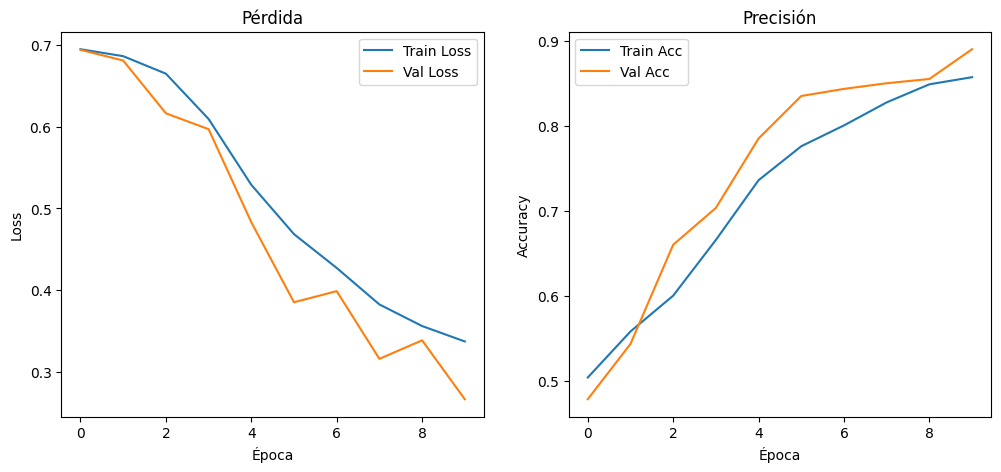

In [11]:
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

# Modelo más pequeño: MobileNetV3 Small
NUM_CLASSES = df_train['label'].nunique()
IMG_SIZE = 224
model = models.mobilenet_v3_small(weights=None)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, NUM_CLASSES)

label_to_idx = {label: idx for idx, label in enumerate(sorted(df_train['label'].unique()))}

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class HagridDataset(Dataset):
    def __init__(self, df, transform=None, label_to_idx=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_idx = self.label_to_idx[label]
        return image, label_idx

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Seleccionar 10% aleatorio de cada conjunto
train_frac = 0.1
val_frac = 0.1

df_train_sample = df_train.sample(frac=train_frac, random_state=42)
df_val_sample = df_val.sample(frac=val_frac, random_state=42)

# Crear datasets y dataloaders con el subconjunto
train_dataset = HagridDataset(df_train_sample, transform=train_transform, label_to_idx=label_to_idx)
val_dataset = HagridDataset(df_val_sample, transform=val_transform, label_to_idx=label_to_idx)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"Usando {len(df_train_sample)} imágenes para entrenamiento y {len(df_val_sample)} para validación.")

EPOCHS = 10  # Puedes aumentar a 10 si ves que tu GPU lo soporta

best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validación
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Época {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_mobilenetv3small.pth")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Precisión')
plt.legend()
plt.show()

## 4. Preparación de datos para entrenamiento
- Generadores o loaders por batch
- Augmentación de datos (si aplica)

## 5. Entrenamiento del modelo
- Definición del ciclo de entrenamiento
- Métricas y callbacks
- Visualización de la evolución de la pérdida y precisión

## 6. Evaluación del modelo
- Resultados en el conjunto de validación y test
- Matriz de confusión y métricas por clase

Accuracy en validación: 87.57%
Reporte de clasificación:
              precision    recall  f1-score   support

        stop       0.85      0.91      0.88      3000
   three_gun       0.90      0.84      0.87      3000

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000



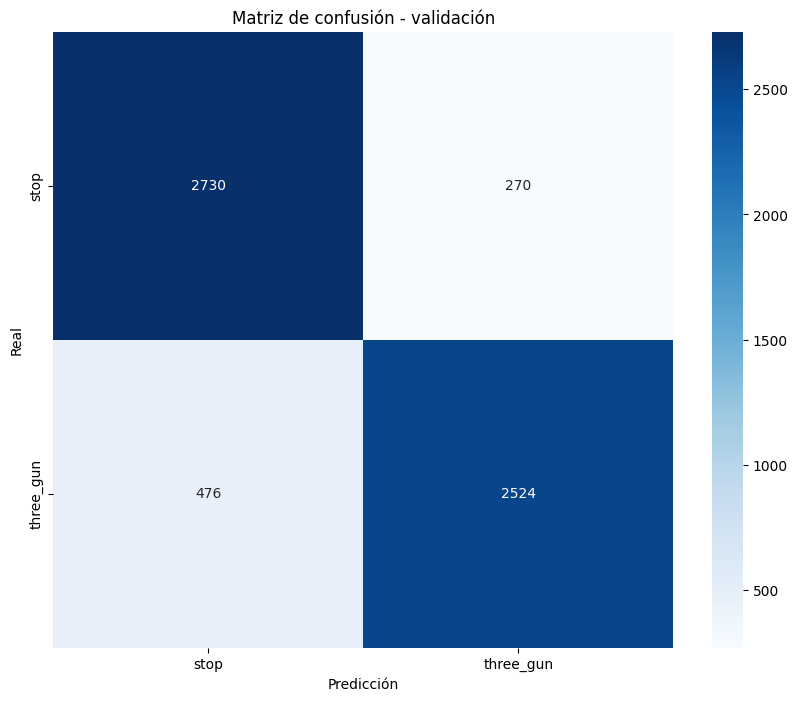

Accuracy en test: 87.66%
Reporte de clasificación:
              precision    recall  f1-score   support

        stop       0.85      0.91      0.88      5000
   three_gun       0.91      0.84      0.87      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



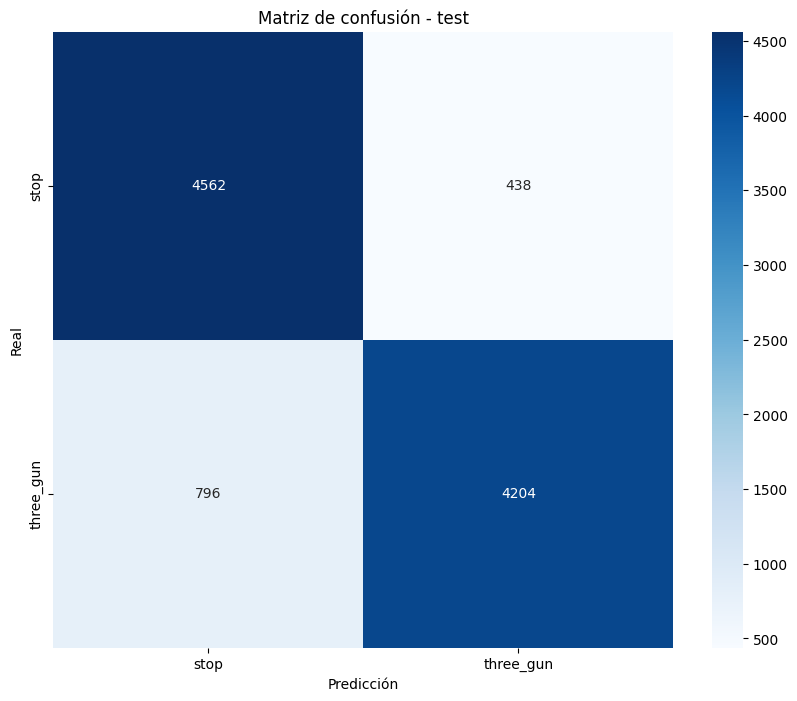

In [13]:
import torch
from torchvision import models, transforms
import torch.nn as nn
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar los DataFrames
df_val = pd.read_csv('../data/hagrid_val.csv')
df_test = pd.read_csv('../data/hagrid_test.csv')

# Diccionario de clases
label_to_idx = {label: idx for idx, label in enumerate(sorted(df_val['label'].unique()))}
idx_to_label = {v: k for k, v in label_to_idx.items()}
NUM_CLASSES = len(label_to_idx)
IMG_SIZE = 224

# Dataset para evaluación
class HagridDataset(Dataset):
    def __init__(self, df, transform=None, label_to_idx=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_idx = self.label_to_idx[label]
        return image, label_idx

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = HagridDataset(df_val, transform=eval_transform, label_to_idx=label_to_idx)
test_dataset = HagridDataset(df_test, transform=eval_transform, label_to_idx=label_to_idx)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Cargar el modelo entrenado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.mobilenet_v3_small(weights=None)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, NUM_CLASSES)
model.load_state_dict(torch.load('best_model_mobilenetv3small.pth', map_location=device))
model = model.to(device)
model.eval()

def evaluate(loader, split_name):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'Accuracy en {split_name}: {acc*100:.2f}%')
    print('Reporte de clasificación:')
    print(classification_report(all_labels, all_preds, target_names=[idx_to_label[i] for i in range(NUM_CLASSES)]))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[idx_to_label[i] for i in range(NUM_CLASSES)],
                yticklabels=[idx_to_label[i] for i in range(NUM_CLASSES)])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de confusión - {split_name}')
    plt.show()

# Evaluar en validación
evaluate(val_loader, 'validación')

# Evaluar en test
evaluate(test_loader, 'test')

## 7. Guardado y exportación del modelo
- Guardar pesos y arquitectura
- Exportar logs/resultados

In [15]:
import os
import torch

# Crear carpeta si no existe
os.makedirs('../data/hagrid_models', exist_ok=True)

# Guardar solo los pesos
torch.save(model.state_dict(), '../data/hagrid_models/best_model_weights.pth')

# Guardar el modelo completo (incluye arquitectura y pesos)
torch.save(model, '../data/hagrid_models/best_model_full.pt')

# Exportar logs/resultados de entrenamiento
import pandas as pd

logs_df = pd.DataFrame({
    'epoch': list(range(1, len(train_losses)+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs
})
logs_df.to_csv('../data/hagrid_models/training_logs.csv', index=False)

print("Pesos guardados en: ../data/hagrid_models/best_model_weights.pth")
print("Modelo completo guardado en: ../data/hagrid_models/best_model_full.pt")
print("Logs de entrenamiento guardados en: ../data/hagrid_models/training_logs.csv")

Pesos guardados en: ../data/hagrid_models/best_model_weights.pth
Modelo completo guardado en: ../data/hagrid_models/best_model_full.pt
Logs de entrenamiento guardados en: ../data/hagrid_models/training_logs.csv


## 8. Conclusiones
- Resumen de resultados
- Recomendaciones para mejoras futuras